# Project 1: MNIST data - Handwritten Digits Processing 

## O. Background

The MNIST database of handwritten digits is one of the most commonly used dataset for training various image processing systems and machine learning algorithms. MNIST has a training set of 60,000 examples, and a test set of 10,000 examples. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. MNIST is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. The original black and white (bilevel) images from NIST were size normalized. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. The images were centered in a $28 \times28$ image by computing the center of mass of the pixels, and translating the image so as to position this point at the center of the $28\times28$ field.

## I. Import data and splitting

In [2]:
import timeit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn import metrics
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D,BatchNormalization,Dropout
from keras.constraints import maxnorm
from keras.wrappers.scikit_learn import KerasClassifier
from keras.metrics import SparseCategoricalCrossentropy
from keras.backend import sum, mean, argmax

In [3]:
#loading data
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


## II. EDA

The corresponding label is: 5
Thus it matches the label from Y_train.


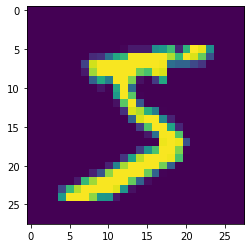

In [ ]:
sample=0
plt.imshow(X_train[sample]/255) #it should be 5
print('The corresponding label is: %d'%(Y_train[sample]))
print("Thus it matches the label from Y_train.")

In [4]:
print('The dimension of X_train is',X_train.shape,', and X_test is ',X_test.shape)
range_train=np.max(X_train)-np.min(X_train)
range_test=np.max(X_test)-np.min(X_test)
#Normalization
X_train=X_train/range_train
X_test=X_test/range_test
X_train=np.reshape(X_train, (X_train.shape[0], -1))
X_test=np.reshape(X_test, (X_test.shape[0], -1))
n_test=len(X_test)
print('After processing, the dimension of X_train is',X_train.shape,', and X_test is ',X_test.shape)

The dimension of X_train is (60000, 28, 28) , and X_test is  (10000, 28, 28)
After processing, the dimension of X_train is (60000, 784) , and X_test is  (10000, 784)


In [ ]:
OHE=OneHotEncoder(sparse=False)
Y_train_ohe=OHE.fit_transform(Y_train.reshape(-1,1))
Y_test_ohe=OHE.fit_transform(Y_test.reshape(-1,1))
#print(Y_train_ohe[0:9,])
#print(Y_test_ohe[0:9,])

Therefore we have a overall understanding of the dataset: 

(a) The plot of first sample is shown above, and the corresponding label is 5, which is consistent with our perspective. 

(b) The dimension of training and testing data of X are $60000*28*28$ and $10000*28*28$ respectively. For process convenience, we may reshape the image from $28*28$ to $784*1$.

(c) The one-hot encoding is done above, and it turns every label to a $1*K$ array with 0 and 1. This not only solves the problem that the classifier can't deal with the classification well as the labels are numbers which can have implicit meaning of actual digit values, but better explaining the Euclidian distance of labels and predict in 2D.

## III. Before Deep Learning

We'll implement KNN, AdaBoost.M1, Decision Tree C4.5, SVM with Gaussian Kernel in this part, and we'll set the timer for each algorithm.

In [ ]:
#KNN with best hyperparameter n_neighbors=3
start = timeit.default_timer()
KNN=KNeighborsClassifier(n_neighbors=3)
KNN.fit(X_train,Y_train_ohe)
err_knn=1-KNN.score(X_test,Y_test_ohe)
stop = timeit.default_timer()
time_knn=stop-start
print('The time to train 60,000 images and test 10000 images with KNN is ', time_knn, 'seconds')

The time to train 60,000 images and test 10000 images with KNN is  40.29228622399998 seconds


In [ ]:
#AdaBoost.M1: As AdaBoost only use 1d array for y, we use Y_train here
#Note: This may take a long time
start = timeit.default_timer()
base=DecisionTreeClassifier(max_depth=30)
ABC=AdaBoostClassifier(base,n_estimators=15)
ABC.fit(X_train,Y_train)
err_abc=1-ABC.score(X_test,Y_test)
stop = timeit.default_timer()
time_abc=stop-start
print('The time to train 60,000 images and test 10000 images with AdaBoost.M1 is ', time_abc, 'seconds')

The time to train 60,000 images and test 10000 images with AdaBoost.M1 is  264.590445222 seconds


In [ ]:
#Decision Tree.C4.5
##As scikit-learn use best algorithm among CART and CART is similar to C4.5, we directly implement CART here
##We use gridsearchcv to find best hyperparameter 
start = timeit.default_timer()
#params = {'min_samples_split': list(range(2,15,2)),'min_samples_leaf':list(range(2,15,2))}
#gscv = GridSearchCV(DecisionTreeClassifier(random_state=20),params)
#gscv.fit(X_train,Y_train_ohe)
#print(gscv.best_estimator_)#DecisionTreeClassifier(random_state=20,min_samples_split=8,min_samples_leaf=6)
DTC=DecisionTreeClassifier(random_state=20,min_samples_split=8,min_samples_leaf=6,max_depth=15)
DTC.fit(X_train,Y_train_ohe)
err_dtc=1-DTC.score(X_test,Y_test_ohe)
#print(err_dtc)
stop = timeit.default_timer()
time_dtc=stop-start
print('The time to train 60,000 images and test 10000 images with Decision Tree CART is ', time_dtc, 'seconds')

The time to train 60,000 images and test 10000 images with Decision Tree CART is  19.50442509000004 seconds


In [ ]:
#SVM with gaussian kernel
##We use gridsearchcv to find best hyperparameter is max_depth=15,max_leaf_nodes=90 
start = timeit.default_timer()
#params = {'C':list(range(1,6))}
#gscv = GridSearchCV(SVC(kernel='rbf'),params,refit=True)
#gscv.fit(X_train,Y_train)
#print(gscv.best_estimator_)
#grid_predictions = grid.predict(X_test)
#print(confusion_matrix(y_test,grid_predictions))
#print(classification_report(y_test,grid_predictions))
SVM=SVC(kernel='rbf',C=3)
SVM.fit(X_train,Y_train)
err_svm=1-SVM.score(X_test,Y_test)
#print(err_svm)
stop = timeit.default_timer()
time_svm=stop-start
print('The time to train 60,000 images and test 10000 images with SVM: Gaussian Kernel is ', time_svm, 'seconds')

The time to train 60,000 images and test 10000 images with SVM: Gaussian Kernel is  350.46499961800004 seconds


In [ ]:
#test errors for above 4 classifiers
print('The error of KNN is %2f'%(err_knn*100)+'%', 'and the running time is %3fs.'%(time_knn))
print('The error of AdaBoost.M1 is %2f'%(err_abc*100)+'%','and the running time is %3fs.'%(time_abc))
print('The error of Decision Tree.CART is %2f'%(err_dtc*100)+'%','and the running time is %3fs.'%(time_dtc))
print('The error of SVM with gaussian kernel is %2f'%(err_svm*100)+'%','and the running time is %3fs.'%(time_svm))

The error of KNN is 3.050000% and the running time is 40.292286s.
The error of AdaBoost.M1 is 4.180000% and the running time is 264.590445s.
The error of Decision Tree.CART is 13.540000% and the running time is 19.504425s.
The error of SVM with gaussian kernel is 1.660000% and the running time is 350.465000s.


We may see all test errors above, and comments are as below:

1. The KNN implement has a lower test error than that in the paper, which is possibly caused by the parameter tuning.

2. AdaBoost.M1 has similar performance but still has lower error as the baseline model is possible to be different.

3. We can also see that the decision tree performs worse than 4.5% with the test error at around 10.8% even we have already do the parameter tuning using grid search. This is because the algorithm has the curse of dimensionality from 2d images and it uses CART instead of C4.5, and I think random forest may perform much better than a single decision tree.

4. Also, the svm with gaussian kernel with parameter tuning on $C$ has test error of 1.66% where $C=4$, and we can't do parameter tuning (or to say, it's very time consuming to do parameter tuning) for other parameters on the computer due to the large dimensionality.

---
Improvement of Decision Tree:

---

In [ ]:
#Random Forest
start = timeit.default_timer()
RFC=RandomForestClassifier(random_state=20,n_estimators=200,max_depth=20)
RFC.fit(X_train,Y_train)
err_rfc=1-RFC.score(X_test,Y_test)
#print(err_rfc)
stop = timeit.default_timer()
time_rfc=stop-start
print('The error of Random Forest is %2f'%(err_rfc*100)+'%','and the running time is %3fs.'%(time_rfc))

The error of Random Forest is 2.920000% and the running time is 82.710147s.


Then, we try to do the hyperparameter tuning for SVM to have a better error rate among all machine learning methods:

In [ ]:
#SVM with hyperparameter tuning
start = timeit.default_timer()
SVM=SVC(kernel='rbf',C=4)
SVM.fit(X_train,Y_train)
err_svm_=1-SVM.score(X_test,Y_test)
#print(err_svm)
stop = timeit.default_timer()
time_svm_=stop-start
print('The error of SVM with C=4 is %2f'%(err_svm_*100)+'%','and the running time is %3fs.'%(time_svm_))

The error of SVM with C=4 is 1.570000% and the running time is 343.980443s.


After hyperparameter tuning, we can see the error rate of SVM drops from 1.66% to 1.57% and is the best among all methods. But we also noticed that the best result comes at the cost of time.

## IV. Deep Learning

### (i). 1-layer neural network

We first start from a single layer neural network with 100 hidden units: (e.g. with architecture: 784 $\rightarrow$ 100 $\rightarrow$ 10)

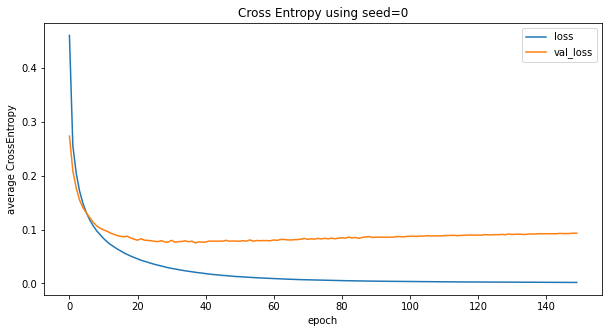

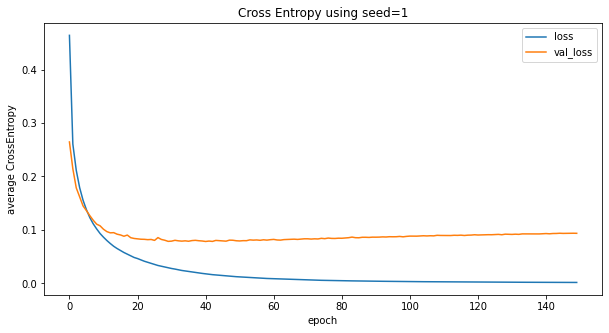

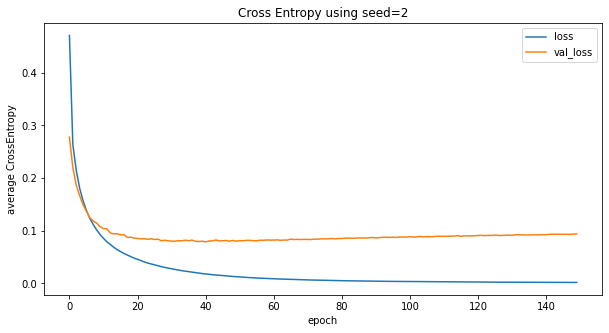

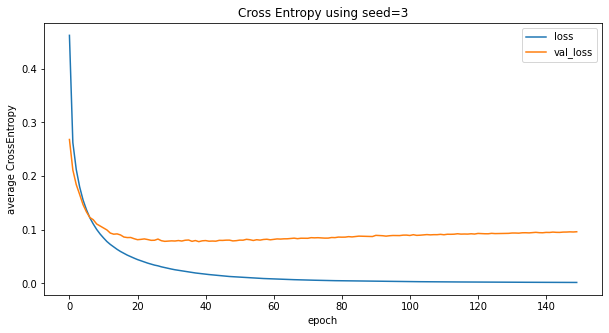

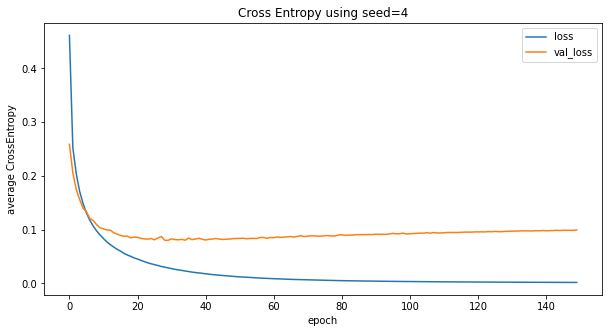

In [20]:
sgd=keras.optimizers.SGD(learning_rate=0.1)
for seed in range(5):
  np.random.seed(seed)
  #Create single layer NN
  ann = Sequential()
  #add one hidden layers
  ann.add(Dense(100,activation='relu',input_shape=(784,)))
  ann.add(Dense(10,activation='softmax'))
  ann.compile(optimizer=sgd,loss=keras.losses.SparseCategoricalCrossentropy(),metrics=[SparseCategoricalCrossentropy()])
  history=ann.fit(X_train,Y_train,epochs=150,validation_split=1/6,shuffle=True,verbose=0,batch_size=100)
  res=pd.DataFrame(history.history)
  res[['loss','val_loss']].plot(figsize=(10,5))
  plt.xlabel('epoch')
  plt.ylabel('average CrossEntropy')
  plt.title('Cross Entropy using seed=%d'%(seed))
  plt.show()

We may find the mean validation error is fluctuating and seem to decrease then increase when the mean training error has a general trend of decreasing, which indicates the occurrence of overfitting. And the validation error will be higher than training error. Then we want to try if this phenomenon also exists if we set test data as the validation set (use the final model in above loop):

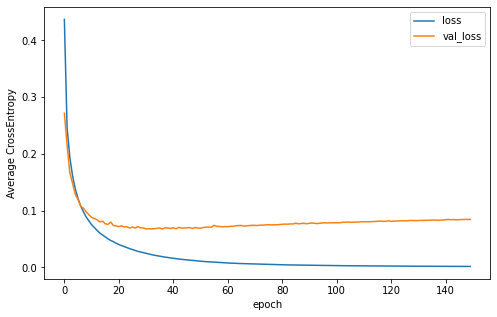

In [21]:
np.random.seed(4)
#Create single layer NN
ann = Sequential()
#add one hidden layers
#ann.add(Flatten())
ann.add(Dense(100,activation='relu',input_shape=(784,)))
ann.add(Dense(10,activation='softmax'))
ann.compile(optimizer=sgd,loss=keras.losses.SparseCategoricalCrossentropy(),metrics=[SparseCategoricalCrossentropy()])
history=ann.fit(X_train,Y_train,epochs=150,validation_data=(X_test,Y_test),verbose=0,batch_size=100)
res=pd.DataFrame(history.history)
res[['loss','val_loss']].plot(figsize=(8,5))
plt.xlabel('epoch')
plt.ylabel('Average CrossEntropy')
plt.show()

And the result also proves our statement.

Then we want to see what's going on if we change the metric as mean misclassification error:

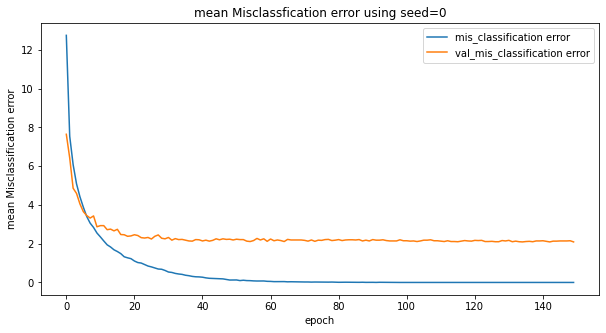

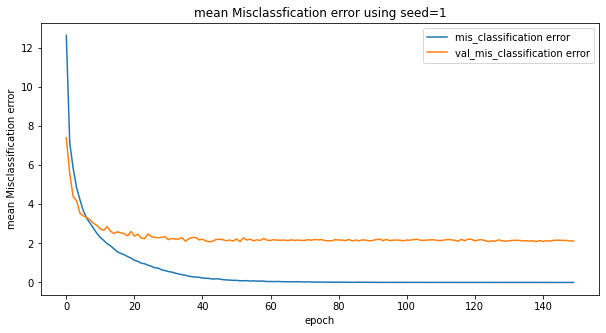

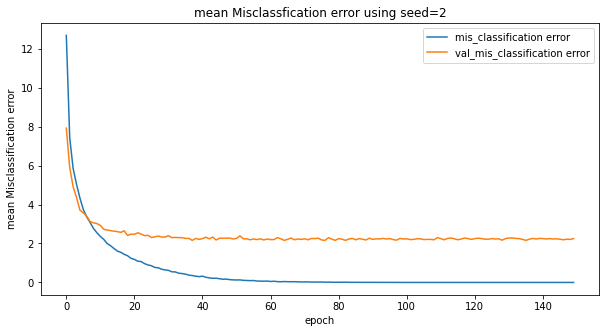

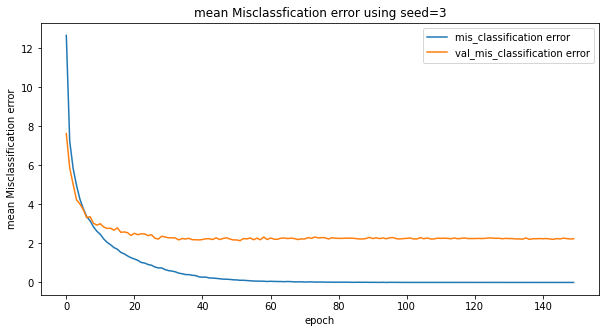

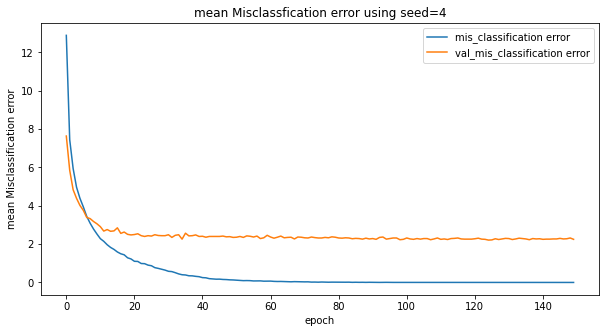

In [14]:
for seed in range(5):
  #Create single layer NN
  ann = Sequential()
  #add one hidden layers
  #ann.add(Flatten())
  ann.add(Dense(100,activation='relu',input_shape=(784,)))
  ann.add(Dense(10,activation='softmax'))
  np.random.seed(seed)
  ann.compile(optimizer=sgd,loss=keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])
  history=ann.fit(X_train,Y_train,epochs=150,validation_split=1/6,shuffle=True,verbose=0,batch_size=100)
  res=pd.DataFrame(history.history)
  res[['mis_classification error','val_mis_classification error']]=(1-res[['accuracy','val_accuracy']])*100
  res[['mis_classification error','val_mis_classification error']].plot(figsize=(10,5))
  plt.xlabel('epoch')
  plt.ylabel('mean Misclassification error')
  plt.title('mean Misclassfication error using seed=%d'%(seed))
  plt.show()

We may see that for all 5 cases with different random seed, the validation misclassification error (loss) are still higher than training, but they generally become stable instead of decreasing or increasing than the case that metric is cross entropy error mentioned above. Besides, the error of training set goes to 0. Still, we use test set to validate our statement, and absolutely it's correct again. 

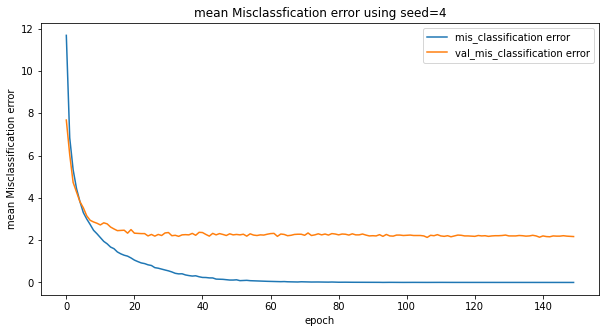

In [15]:
#Create single layer NN
ann = Sequential()
#add one hidden layers
#ann.add(Flatten())
ann.add(Dense(100,activation='relu',input_shape=(784,)))
ann.add(Dense(10,activation='softmax'))
ann.compile(optimizer=sgd,loss=keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])
history=ann.fit(X_train,Y_train,epochs=150,validation_data=(X_test,Y_test),verbose=0,batch_size=100)
res=pd.DataFrame(history.history)
res[['mis_classification error','val_mis_classification error']]=(1-res[['accuracy','val_accuracy']])*100
res[['mis_classification error','val_mis_classification error']].plot(figsize=(10,5))
plt.xlabel('epoch')
plt.ylabel('mean Misclassification error')
plt.title('mean Misclassfication error using seed=%d'%(seed))
plt.show()

We can see the training error by doing above methods, and the best model in my opinion is using the seed=4 and mean misclassification error as the metric as it has a relatively stable validation error and approximately lower error rate. and we visualize its weights:

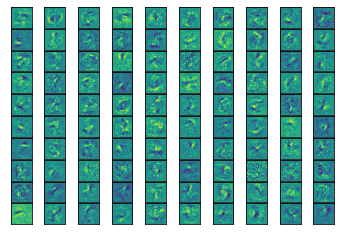

In [17]:
W = ann.layers[0].get_weights()[0].reshape(28,28,100)
for i in range(W.shape[2]):
  plt.subplot(10,10,i+1)
  plt.imshow(W[:,:,i])
  plt.xticks([])
  plt.yticks([])
plt.subplots_adjust(wspace=0.05,hspace=0.05)
plt.show()

It seems that the weight visualization is good, as it'seither not too noisy or not too correlated.

Then we tried to do the parameter tuning for learning rate in $\{0.01,0.1,0.2,0.5\}$ and momentum in $\{0.0,0.5,0.9\}$:

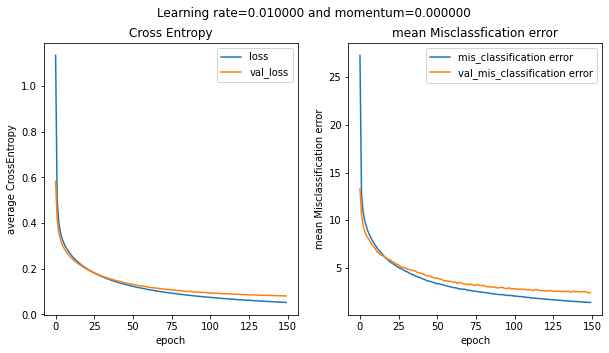

In this case, the misclassification error for test set is 2.410001%.


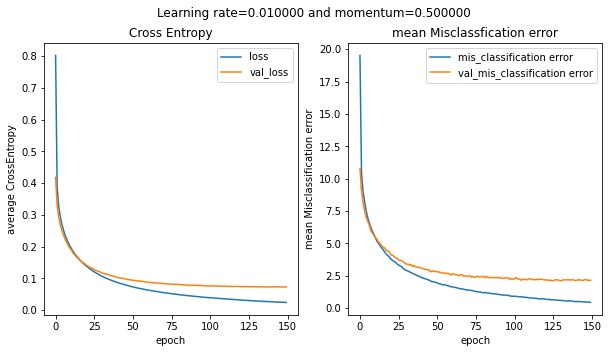

In this case, the misclassification error for test set is 2.149999%.


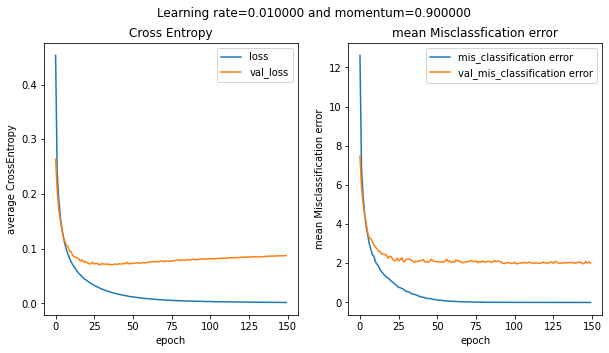

In this case, the misclassification error for test set is 2.010000%.


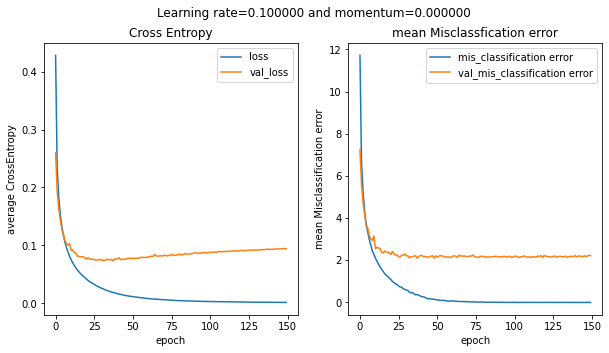

In this case, the misclassification error for test set is 2.230000%.


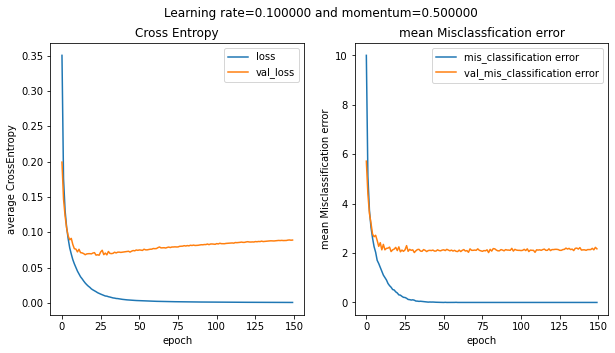

In this case, the misclassification error for test set is 2.170002%.


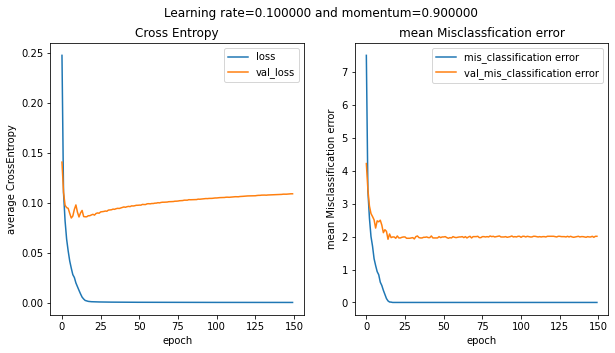

In this case, the misclassification error for test set is 2.010000%.


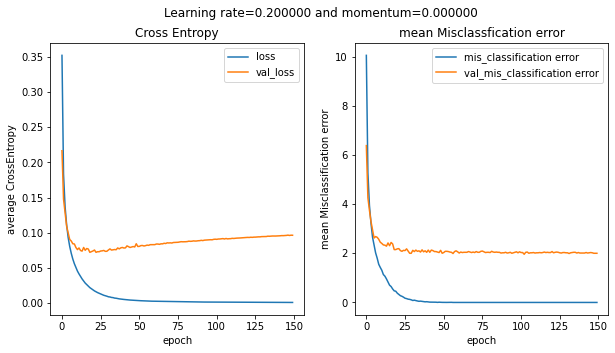

In this case, the misclassification error for test set is 1.999998%.


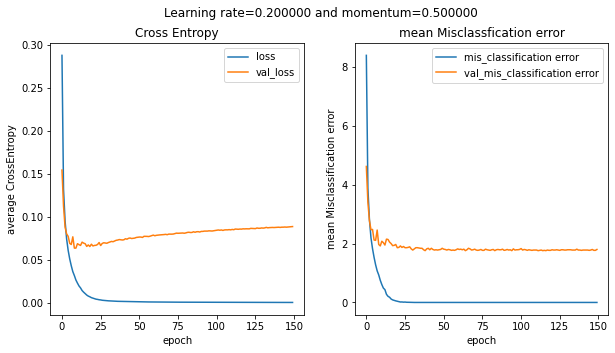

In this case, the misclassification error for test set is 1.800001%.


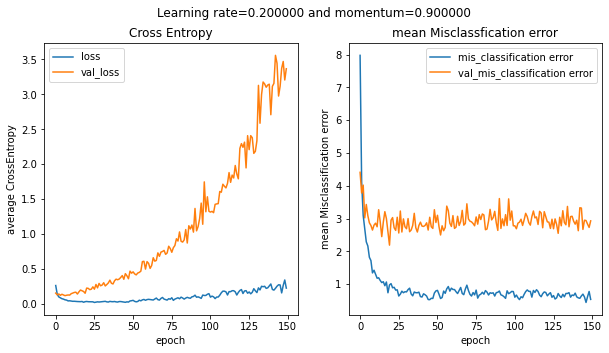

In this case, the misclassification error for test set is 2.929997%.


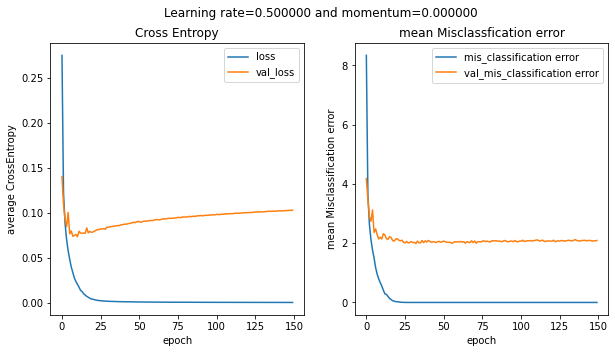

In this case, the misclassification error for test set is 2.090001%.


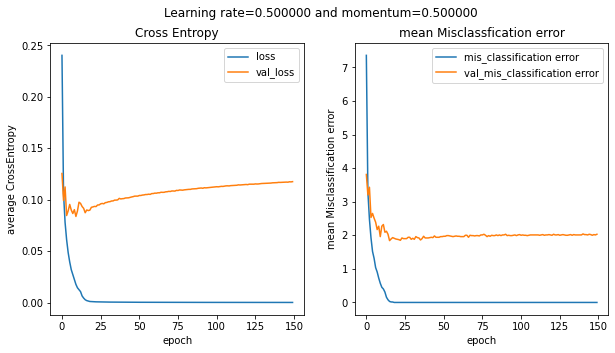

In this case, the misclassification error for test set is 2.029997%.


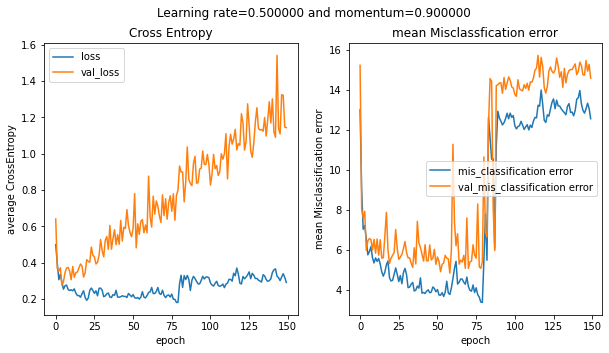

In this case, the misclassification error for test set is 14.590001%.


In [18]:
seed=4
for lr in [0.01,0.1,0.2,0.5]:
  for momentum in [0,0.5,0.9]:
    sgd=keras.optimizers.SGD(learning_rate=lr,momentum=momentum)
    np.random.seed(seed)
    #Create single layer NN
    ann = Sequential()
    #add one hidden layers
    #ann.add(Flatten())
    ann.add(Dense(100,activation='relu',input_shape=(784,)))
    ann.add(Dense(10,activation='softmax'))
    ann.compile(optimizer=sgd,loss=keras.losses.SparseCategoricalCrossentropy(),metrics=[SparseCategoricalCrossentropy(),'accuracy'])
    history=ann.fit(X_train,Y_train,epochs=150,validation_data=(X_test,Y_test),verbose=0,batch_size=100)
    f,ax=plt.subplots(1,2,figsize=(14,7))
    res=pd.DataFrame(history.history)
    res[['mis_classification error','val_mis_classification error']]=(1-res[['accuracy','val_accuracy']])*100
    res[['loss','val_loss']].plot(figsize=(15,5),ax=ax[0])
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('average CrossEntropy')
    ax[0].set_title('Cross Entropy')
    res[['mis_classification error','val_mis_classification error']].plot(figsize=(10,5),ax=ax[1])
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('mean Misclassification error')
    ax[1].set_title('mean Misclassfication error')
    f.suptitle('Learning rate=%2f and momentum=%2f'%(lr,momentum))
    plt.show()
    print("In this case, the misclassification error for test set is %3f"%(res['val_mis_classification error'][149])+'%.')

From the result above, we may see the best parameter set of learning rate and momentum is $\{lr=0.2,momentum=0.5\}$ because:

- when lr=0.01, the error rate decrease slower than that when lr>0.01
- This combination has the lowest error rate, though there seems to be an overfitting regarding to cross entropy.

The parameter tuning method we used above is grid search. Actually, if we controls the momentum and only see the learning rate, we can see the convergence properties of this algorithm is when lr become larger ($lr>0.1$), the convergence will become faster; As for momentum, we can see if we control the lr (when $lr \neq 0.01$), when momentum is increasing, the algorithm also decrease faster in error. We also noticed that when lr and momentum is both large, an overfitting may occur and the testing error goes up.

### (ii). CNN with one layer of 2-D Convolution and pooling

We'll redo the steps we done in (i) but switch our neural network to CNN with one time of 2-D convolution. For the sake of saving time, we'll no longer set 5 seeds but directly set `seed=4` and we'll do several steps together and compare their results directly. As for the epoch, we'll set the epoch to the value that the training error becomes stable and change little. Before we started, we reshape the data first as we'll do the neural network directly on 2-D space.

In [20]:
#Reshape the data
X_train=X_train.reshape(-1,28,28,1)
X_test=X_test.reshape(-1,28,28,1)

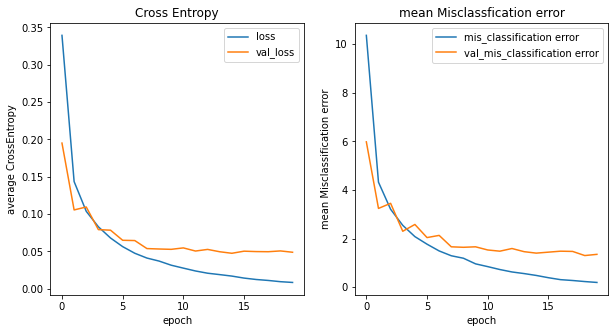

In [21]:
np.random.seed(4)
sgd=keras.optimizers.SGD(learning_rate=0.1)
#Create single layer NN
cnn_1 = Sequential()
#add one hidden layers
cnn_1.add(Conv2D(32, (3,3), padding="same", activation="relu", input_shape=(28,28,1)))
cnn_1.add(MaxPooling2D(2, 2))
cnn_1.add(Flatten())
cnn_1.add(Dense(100,activation='relu'))
cnn_1.add(Dense(10,activation='softmax'))
cnn_1.compile(optimizer=sgd,loss=keras.losses.SparseCategoricalCrossentropy(),metrics=[SparseCategoricalCrossentropy(),'accuracy'])
history=cnn_1.fit(X_train,Y_train,epochs=20,validation_data=(X_test,Y_test),verbose=0,batch_size=100)
f,ax=plt.subplots(1,2,figsize=(14,7))
res=pd.DataFrame(history.history)
res[['mis_classification error','val_mis_classification error']]=(1-res[['accuracy','val_accuracy']])*100
res[['loss','val_loss']].plot(figsize=(15,5),ax=ax[0])
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('average CrossEntropy')
ax[0].set_title('Cross Entropy')
res[['mis_classification error','val_mis_classification error']].plot(figsize=(10,5),ax=ax[1])
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('mean Misclassification error')
ax[1].set_title('mean Misclassfication error')
plt.show()

From the model training process above, when epoch reaches 10, the mean misclassification error seem to be stable. Between two metrics, we may consider more on the mean misclassification error as cross entropy seems to go up when epoch>5, but actually at this time the overall accuracy is not going down. 

Then we continue doing parameter tuning with epoch=20, but this time we consider learning rate in $\{0.01,0.1,0.2,0.3\}$ and momentum in $\{0.1,0.3,0.5\}$

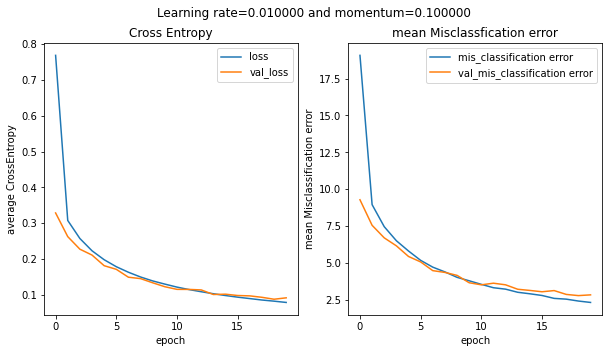

In this case, the misclassification error for test set is 2.850002%.


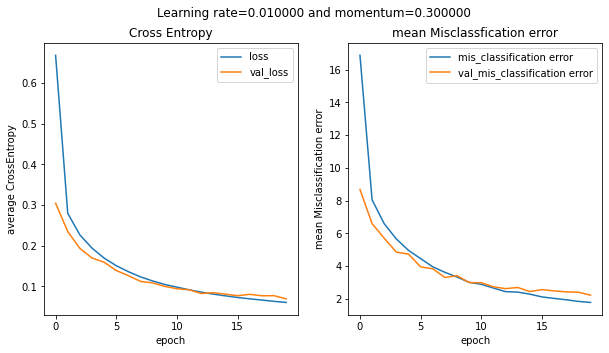

In this case, the misclassification error for test set is 2.219999%.


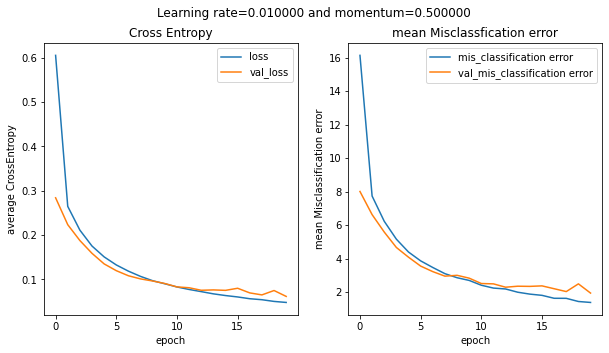

In this case, the misclassification error for test set is 1.950002%.


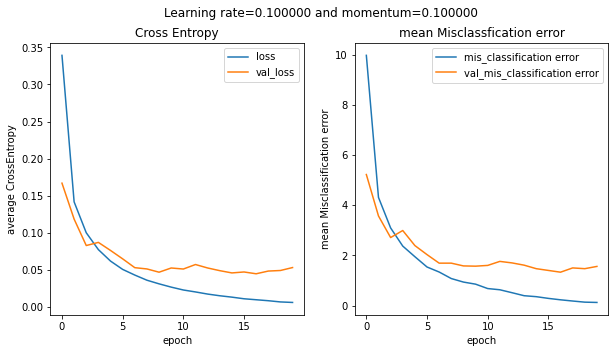

In this case, the misclassification error for test set is 1.560003%.


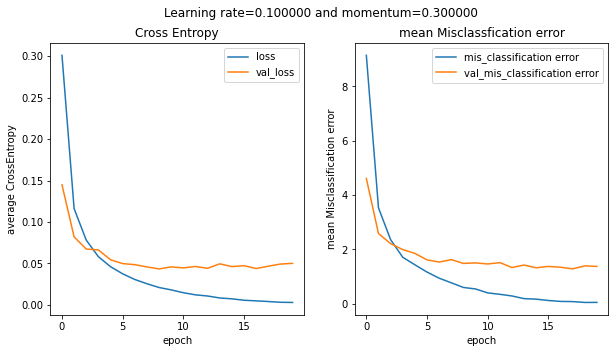

In this case, the misclassification error for test set is 1.370001%.


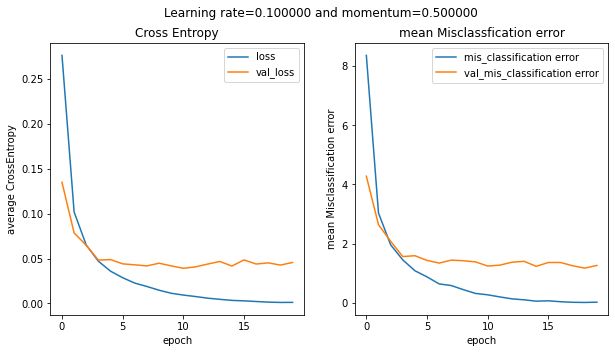

In this case, the misclassification error for test set is 1.260000%.


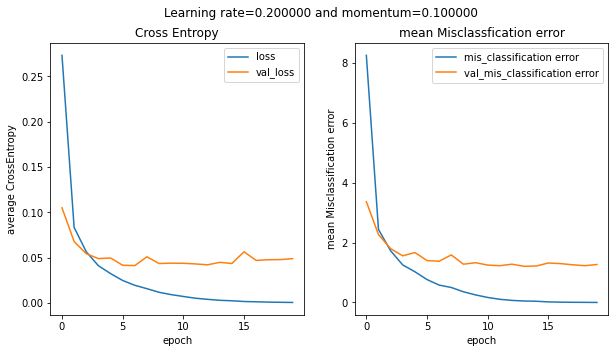

In this case, the misclassification error for test set is 1.270002%.


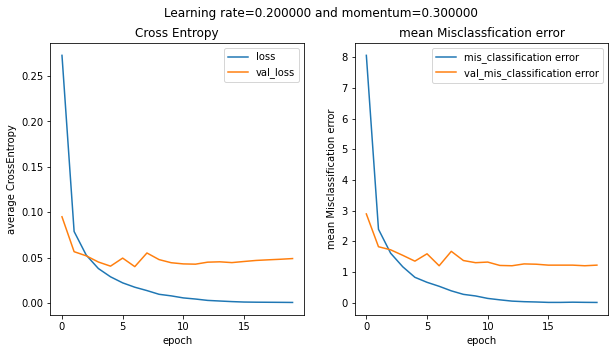

In this case, the misclassification error for test set is 1.220000%.


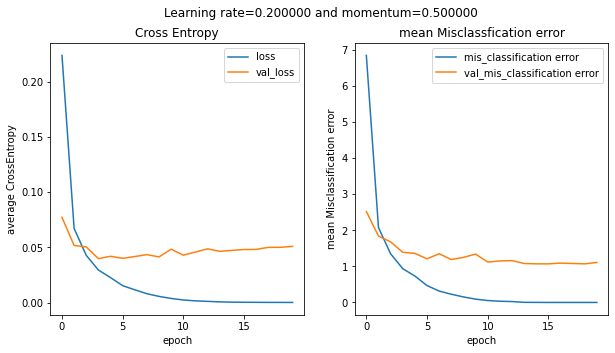

In this case, the misclassification error for test set is 1.109999%.


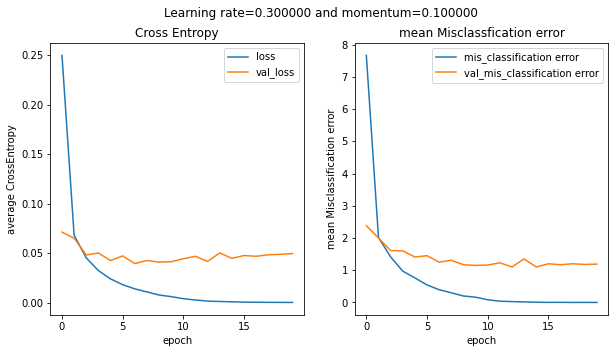

In this case, the misclassification error for test set is 1.190001%.


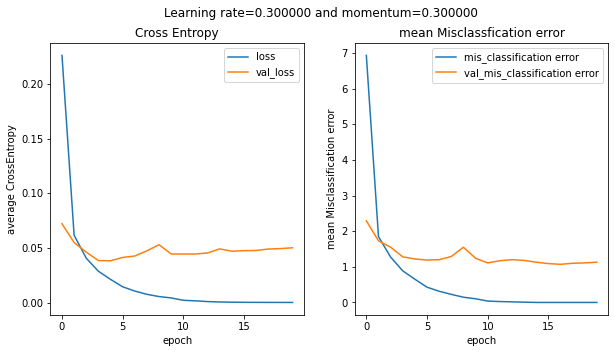

In this case, the misclassification error for test set is 1.130003%.


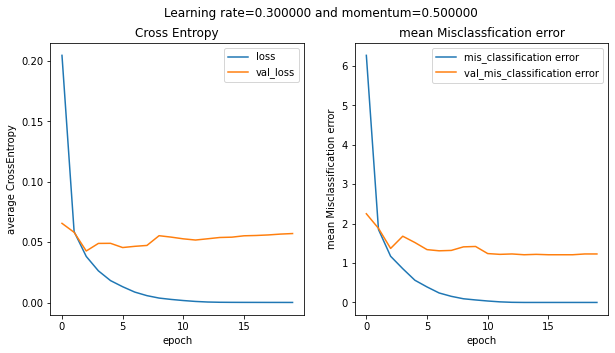

In this case, the misclassification error for test set is 1.230001%.


In [22]:
seed=4
for lr in [0.01,0.1,0.2,0.3]:
  for momentum in [0.1,0.3,0.5]:
    sgd=keras.optimizers.SGD(learning_rate=lr,momentum=momentum)
    np.random.seed(seed)
    #Create single layer NN
    cnn_1 = Sequential()
    #add one hidden layers
    cnn_1.add(Conv2D(32, (3,3), padding="same", activation="relu", input_shape=(28,28,1)))
    cnn_1.add(MaxPooling2D(2, 2))
    cnn_1.add(Flatten())
    cnn_1.add(Dense(100,activation='relu'))
    cnn_1.add(Dense(10,activation='softmax'))
    cnn_1.compile(optimizer=sgd,loss=keras.losses.SparseCategoricalCrossentropy(),metrics=[SparseCategoricalCrossentropy(),'accuracy'])
    history=cnn_1.fit(X_train,Y_train,epochs=20,validation_data=(X_test,Y_test),verbose=0,batch_size=100)
    f,ax=plt.subplots(1,2,figsize=(14,7))
    res=pd.DataFrame(history.history)
    res[['mis_classification error','val_mis_classification error']]=(1-res[['accuracy','val_accuracy']])*100
    res[['loss','val_loss']].plot(figsize=(15,5),ax=ax[0])
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('average CrossEntropy')
    ax[0].set_title('Cross Entropy')
    res[['mis_classification error','val_mis_classification error']].plot(figsize=(10,5),ax=ax[1])
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('mean Misclassification error')
    ax[1].set_title('mean Misclassfication error')
    f.suptitle('Learning rate=%2f and momentum=%2f'%(lr,momentum))
    plt.show()
    print("In this case, the misclassification error for test set is %3f"%(res['val_mis_classification error'][19])+'%.')

From above parameter tuning process, we can see the best model is with parameter $\{lr=0.2,momentum=0.5\}$ with the mean misclassfication error=1.11%. Clearly, this algorithm outperforms the single layer NN in testing because it directly use 2-D data and the convolution and pooling process makes it more stable. Also, the visualization of the weight is shown below.

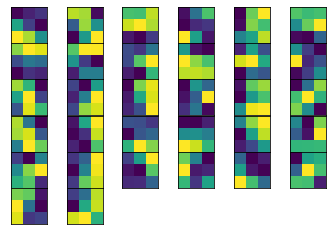

In [23]:
seed=4
sgd=keras.optimizers.SGD(learning_rate=0.2,momentum=0.5)
np.random.seed(seed)
#Create single layer NN
cnn_1 = Sequential()
#add one hidden layers
cnn_1.add(Conv2D(32, (3,3), padding="same", activation="relu", input_shape=(28,28,1)))
cnn_1.add(MaxPooling2D(2, 2))
cnn_1.add(Flatten())
cnn_1.add(Dense(100,activation='relu'))
cnn_1.add(Dense(10,activation='softmax'))
cnn_1.compile(optimizer=sgd,loss=keras.losses.SparseCategoricalCrossentropy(),metrics=[SparseCategoricalCrossentropy(),'accuracy'])
history=cnn_1.fit(X_train,Y_train,epochs=20,validation_data=(X_test,Y_test),verbose=0,batch_size=100)
W = cnn_1.layers[0].get_weights()[0].reshape(3,3,-1)
for i in range(W.shape[2]):
  plt.subplot(6,6,i+1)
  plt.imshow(W[:,:,i])
  plt.xticks([])
  plt.yticks([])
plt.subplots_adjust(wspace=0.01,hspace=0.01)
plt.show()

The weight from the best model seems good as it's either not too noisy or too correlated.

### (iii). CNN with three times of 2D convolution

In this part, we hope to improve the algorithm above, and two more times of convolution and pooling are added with batch normalization to avoid overfitting. Still, we set seed=4, epoch=20 and learning rate=0.1 to test the performance of this model:

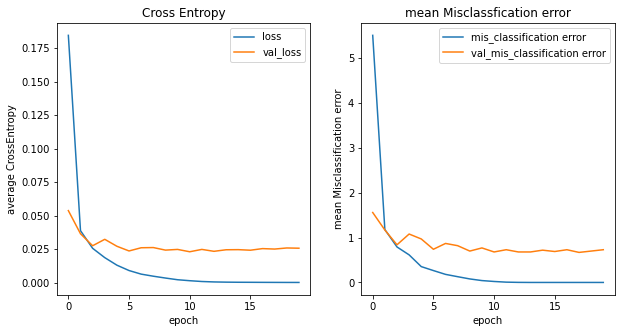

In [ ]:
np.random.seed(4)
sgd=keras.optimizers.SGD(learning_rate=0.1)
#create model
cnn = Sequential()
#add model layers
cnn.add(Conv2D(32, (3,3), padding="same", activation="relu", input_shape=(28,28,1)))
cnn.add(MaxPooling2D(2, 2))
cnn.add(BatchNormalization())
cnn.add(Conv2D(64, (3,3), padding="same", activation="relu"))
cnn.add(MaxPooling2D(2, 2))
cnn.add(BatchNormalization())
cnn.add(Conv2D(64, (3,3), padding="same", activation="relu"))
cnn.add(Flatten())
cnn.add(Dense(64, activation="relu"))
cnn.add(Dense(10))
#compile model using accuracy to measure model performance
cnn.compile(optimizer=sgd,loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[SparseCategoricalCrossentropy(),'accuracy'])
#train CNN
history=cnn.fit(X_train,Y_train,epochs=20,validation_data=(X_test,Y_test),verbose=0,batch_size=100)#can reach accuracy to nearly 99%
f,ax=plt.subplots(1,2,figsize=(14,7))
res=pd.DataFrame(history.history)
res[['mis_classification error','val_mis_classification error']]=(1-res[['accuracy','val_accuracy']])*100
res[['loss','val_loss']].plot(figsize=(15,5),ax=ax[0])
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('average CrossEntropy')
ax[0].set_title('Cross Entropy')
res[['mis_classification error','val_mis_classification error']].plot(figsize=(10,5),ax=ax[1])
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('mean Misclassification error')
ax[1].set_title('mean Misclassfication error')
plt.show()

We can see it did perform better than cnn with 1 time of convolution. Then we do the parameter tuning, again with parameter set epoch=20, learning rate in $\{0.01,0.1,0.2,0.3\}$ and momentum in $\{0.1,0.3,0.5\}$:

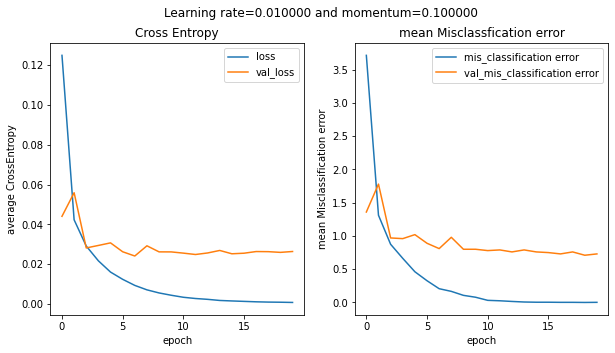

In this case, the misclassification error for test set is 0.800002%.


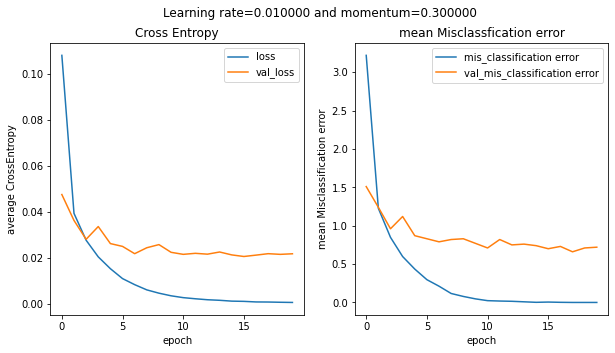

In this case, the misclassification error for test set is 0.770003%.


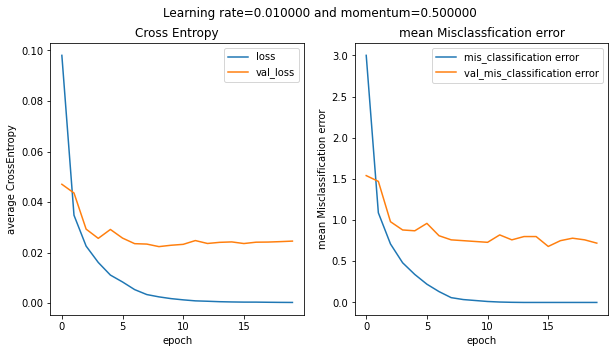

In this case, the misclassification error for test set is 0.739998%.


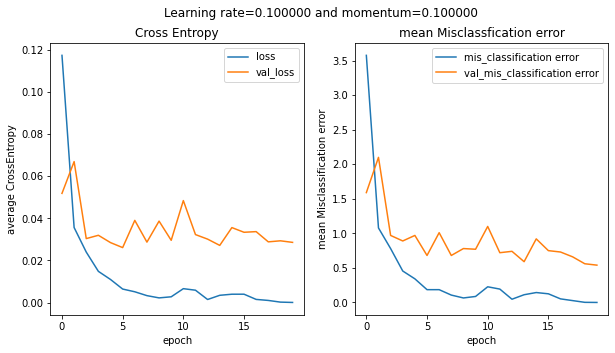

In this case, the misclassification error for test set is 0.770003%.


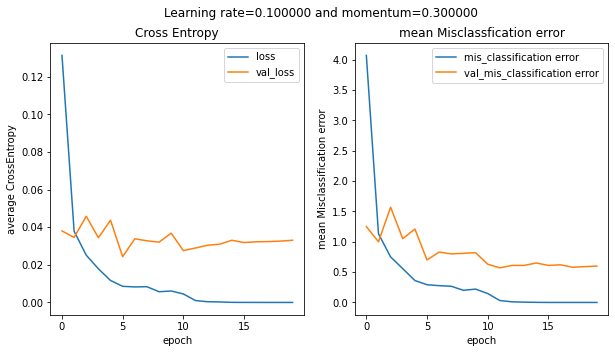

In this case, the misclassification error for test set is 0.819999%.


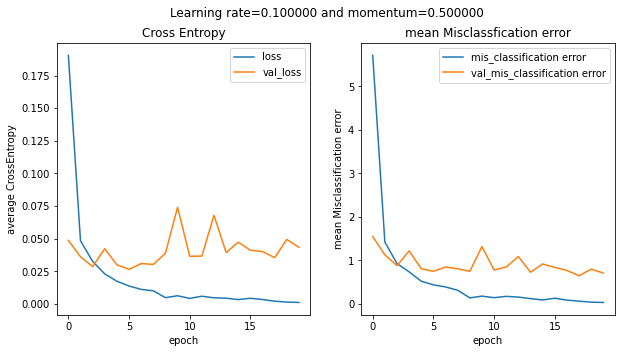

In this case, the misclassification error for test set is 1.319999%.


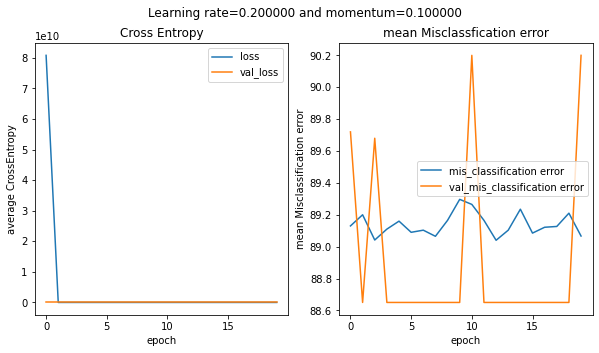

In this case, the misclassification error for test set is 88.650000%.


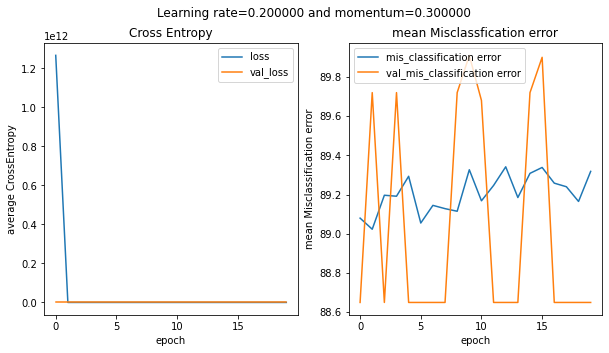

In this case, the misclassification error for test set is 89.910000%.


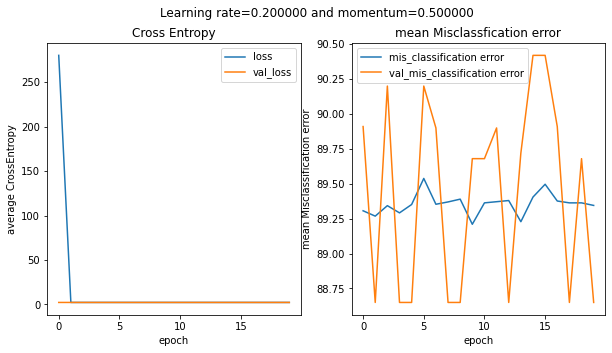

In this case, the misclassification error for test set is 89.680000%.


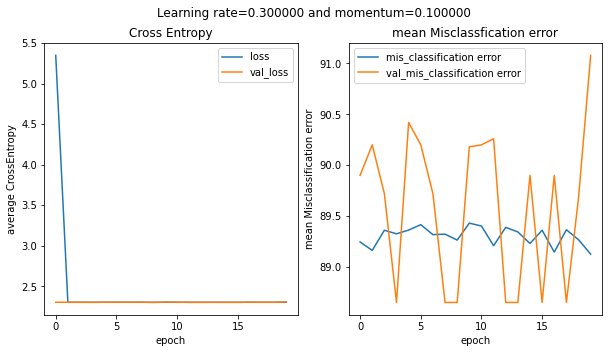

In this case, the misclassification error for test set is 90.180000%.


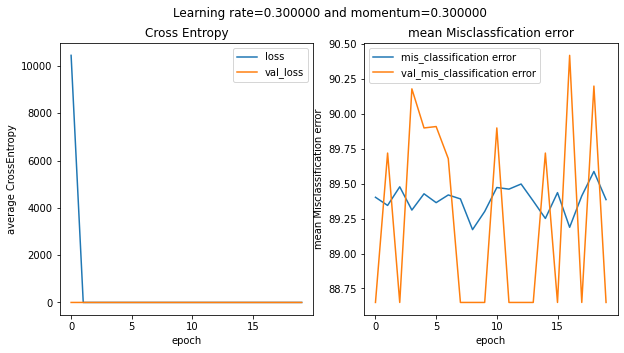

In this case, the misclassification error for test set is 88.650000%.


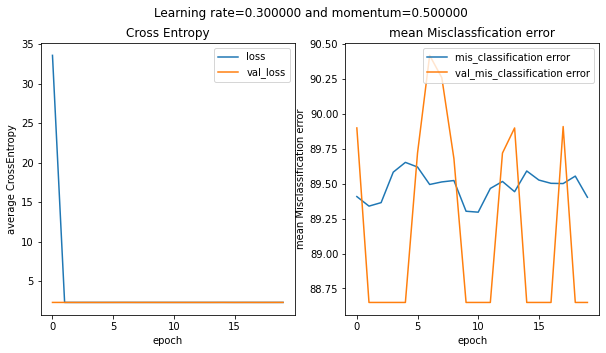

In this case, the misclassification error for test set is 88.650000%.


In [ ]:
seed=4
for lr in [0.01,0.1,0.2,0.3]:
  for momentum in [0.1,0.3,0.5]:
    sgd=keras.optimizers.SGD(learning_rate=lr,momentum=momentum)
    np.random.seed(seed)
    #create model
    cnn = Sequential()
    #add model layers
    cnn.add(Conv2D(32, (3,3), padding="same", activation="relu", input_shape=(28,28,1)))
    cnn.add(MaxPooling2D(2, 2))
    cnn.add(BatchNormalization())
    cnn.add(Conv2D(64, (3,3), padding="same", activation="relu"))
    cnn.add(MaxPooling2D(2, 2))
    cnn.add(BatchNormalization())
    cnn.add(Conv2D(64, (3,3), padding="same", activation="relu"))
    cnn.add(Flatten())
    cnn.add(Dense(64, activation="relu"))
    cnn.add(Dense(10))
    cnn.compile(optimizer=sgd,loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=[SparseCategoricalCrossentropy(),'accuracy'])
    history=cnn.fit(X_train,Y_train,epochs=20,validation_data=(X_test,Y_test),verbose=0)
    f,ax=plt.subplots(1,2,figsize=(14,7))
    res=pd.DataFrame(history.history)
    res[['mis_classification error','val_mis_classification error']]=(1-res[['accuracy','val_accuracy']])*100
    res[['loss','val_loss']].plot(figsize=(15,5),ax=ax[0])
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('average CrossEntropy')
    ax[0].set_title('Cross Entropy')
    res[['mis_classification error','val_mis_classification error']].plot(figsize=(10,5),ax=ax[1])
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('mean Misclassification error')
    ax[1].set_title('mean Misclassfication error')
    f.suptitle('Learning rate=%2f and momentum=%2f'%(lr,momentum))
    plt.show()
    print("In this case, the misclassification error for test set is %3f"%(res['val_mis_classification error'][9])+'%.')

From above parameter tuning process, we can see the best model is with parameter $\{lr=0.01,momentum=0.5\}$ with the mean misclassfication error=0.74%. Clearly, this is far better than CNN with 1 time convolution, single layer NN, and any mentioned machine learning methods like KNN, AdaBoost, Decision Tree, and SVM with best parameter $C=4$. However, for stability, we may still choose $\{lr=0.1,momentum=0.1\}$ with error=0.77%. Also, the visualization of the weight is shown below.

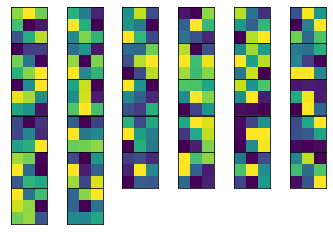

In [ ]:
np.random.seed(4)
sgd=keras.optimizers.SGD(learning_rate=0.1,momentum=0.1)
#create model
cnn = Sequential()
#add model layers
cnn.add(Conv2D(32, (3,3), padding="same", activation="relu", input_shape=(28,28,1)))
cnn.add(MaxPooling2D(2, 2))
cnn.add(BatchNormalization())
cnn.add(Conv2D(64, (3,3), padding="same", activation="relu"))
cnn.add(MaxPooling2D(2, 2))
cnn.add(BatchNormalization())
cnn.add(Conv2D(64, (3,3), padding="same", activation="relu"))
cnn.add(Flatten())
cnn.add(Dense(64, activation="relu"))
cnn.add(Dense(10))
#compile model using accuracy to measure model performance
cnn.compile(optimizer=sgd, loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[SparseCategoricalCrossentropy(),'accuracy'])
#train CNN
history=cnn.fit(X_train,Y_train,epochs=20,validation_data=(X_test,Y_test),verbose=0,batch_size=100)#can reach accuracy to nearly 99%
W = cnn.layers[0].get_weights()[0].reshape(3,3,-1)
for i in range(W.shape[2]):
  plt.subplot(6,6,i+1)
  plt.imshow(W[:,:,i])
  plt.xticks([])
  plt.yticks([])
plt.subplots_adjust(wspace=0.01,hspace=0.01)
plt.show()

The weight from the best model seems good as it's either not too noisy or too correlated.


## V. More about Deep Learning

We first load the model we'll use in this section. In particular, `train.txt`
contains 20,000 lines, `val.txt` and `test.txt` contains 5000 lines in the same format. Each line contains 1569 coordinates, with the first 784 real-valued numbers correspond to the 784 pixel values for the first digit, next 784 real valued numbers correspond to the pixel values for the second digit.

In [ ]:
#need to modify in local jupyter notebook
from google.colab import drive 
!mkdir data
drive.mount('/content/drive')

train=pd.read_csv('drive/MyDrive/Colab Notebooks/Data/train.txt',header=None).to_numpy()
test=pd.read_csv('drive/MyDrive/Colab Notebooks/Data/test.txt',header=None).to_numpy()
val=pd.read_csv('drive/MyDrive/Colab Notebooks/Data/val.txt',header=None).to_numpy()
print(train.shape,test.shape,val.shape)
#train=pd.read_csv('./data/train.txt',header=None).to_numpy()
#test=pd.read_csv('./data/test.txt',header=None).to_numpy()
#val=pd.read_csv('./data/val.txt',header=None).to_numpy()
#print(train.shape,test.shape,val.shape)


Mounted at /content/drive
(20000, 1569) (5000, 1569) (5000, 1569)


And we want to figure out how does one sample in these datasets order, i.e. in row order or in column order, and what's the relationship of the two digits:

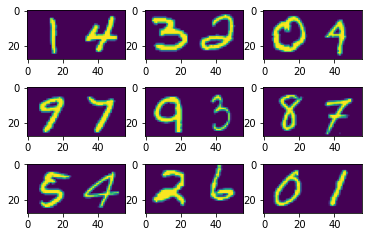

[[ 5.  5.  4.]
 [16. 12. 15.]
 [ 9.  8.  1.]]


In [ ]:
#We plot the first 9 observations, and we stretch out the last feature for reshape
for i in range(9):
  sample=train[i,:1568].reshape(28,56)
  plt.subplot(3,3,i+1)
  plt.imshow(sample)
plt.show()
print(train[0:9,-1].reshape(3,3))

sample=train[0,:1568].reshape(28,56)

Thus, the sample in this dataset is in row order, and the final digit of each line is the sum of two digits, and the first 1568 columns are the decomposition of pixels of two digits.

Again, we will implement CNN with one time convolution and CNN with 3 times of convolutions in these datasets as follows:

- train three models using `train` dataset, while validate these models using `val` dataset, and select the best algorithm based on the validation error;
- report the test error on `test` dataset, compared it to the error achieved from MNIST data.

In [ ]:
X_train,Y_train = train[:,:1568].reshape((-1,28,56,1)), train[:,-1]
X_val,Y_val = val[:,:1568].reshape((-1,28,56,1)), val[:,-1]
X_test,Y_test = test[:,:1568].reshape((-1,28,56,1)), test[:,-1]
classes=np.unique(Y_train).shape[0]
np.unique(Y_train, return_counts=True)

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18.]),
 array([ 180,  424,  664,  886, 1056, 1188, 1378, 1578, 1854, 2026, 1797,
        1552, 1341, 1141,  939,  786,  601,  414,  195]))

From above, we may see the labels from 5 to 13 takes the majority, which is consistent from what we know. Note here the label is the sum of two digits, so we can still consider this problem a classification problem with $(18-0)+1=19$ classes.

### (i).CNN with one time 2-D Convolution 

We first do the CNN with 1 time convolution, and set `epoch=20`, `seed=4`, `lr=0.2` and `momentum=0.3`. 

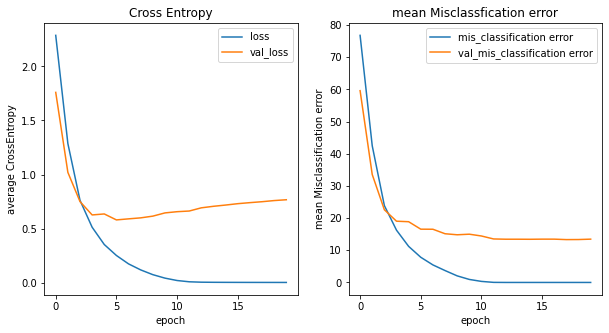

In this case, the misclassification error for vallidation and test set are 14.999998% and 12.480000% respectively.


In [ ]:
np.random.seed(4)
sgd=keras.optimizers.SGD(learning_rate=0.2,momentum=0.3)
#create model
cnn_1 = Sequential()
#add model layers
cnn_1.add(Conv2D(32, (3,3), activation="relu", input_shape=(28,56,1)))
cnn_1.add(MaxPooling2D(2, 2))
cnn_1.add(Flatten())
cnn_1.add(Dense(64, activation="relu"))
cnn_1.add(Dense(classes))
#compile model using accuracy to measure model performance
cnn_1.compile(optimizer=sgd, loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[SparseCategoricalCrossentropy(),'accuracy'])
history=cnn_1.fit(X_train,Y_train,epochs=20,validation_data=(X_val,Y_val),verbose=0)
f,ax=plt.subplots(1,2,figsize=(14,7))
res=pd.DataFrame(history.history)
res[['mis_classification error','val_mis_classification error']]=(1-res[['accuracy','val_accuracy']])*100
res[['loss','val_loss']].plot(figsize=(15,5),ax=ax[0])
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('average CrossEntropy')
ax[0].set_title('Cross Entropy')
res[['mis_classification error','val_mis_classification error']].plot(figsize=(10,5),ax=ax[1])
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('mean Misclassification error')
ax[1].set_title('mean Misclassfication error')
plt.show()
pred = np.argmax(cnn_1.predict(X_test),axis=1)
err_cnn_1 = np.mean(pred!=Y_test)*100
print("In this case, the misclassification error for vallidation and test set are %3f"%
      (res['val_mis_classification error'][9])+'%', 'and %3f'%(err_cnn_1)+'% respectively.')

We can see the mean misclassification error of this case is around 12.5%, which is far more than that in previous question using one time convolution CNN(1.11%). We may see the training error decrease to 0 when epoch goes to around 15 while test error is still around 15%, so we may consider the following parameter tuning process with seed=4, epoch=30 (in case of underfitting), and the parameter set is $\{lr:[0.01,0.1,0.2,0.3], momentum:[0.1,0.3,0.5]\}$.

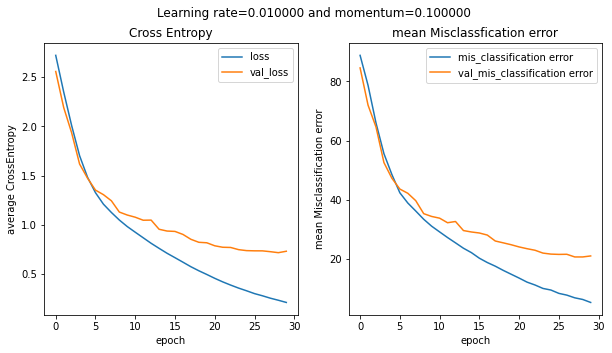

In this case, the misclassification error for vallidation and test set are 34.439999% and 18.940000% respectively.


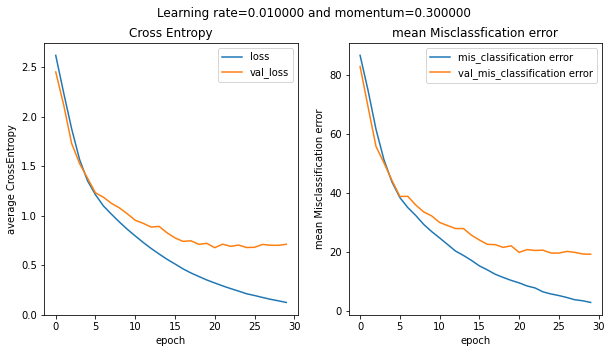

In this case, the misclassification error for vallidation and test set are 32.179999% and 17.580000% respectively.


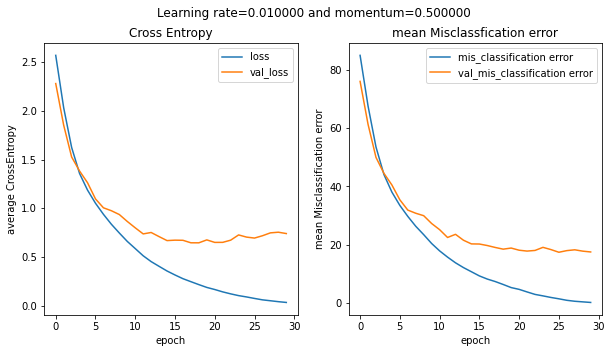

In this case, the misclassification error for vallidation and test set are 27.260000% and 15.840000% respectively.


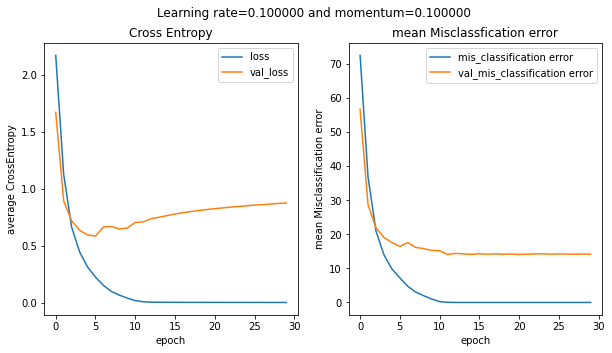

In this case, the misclassification error for vallidation and test set are 15.300000% and 12.560000% respectively.


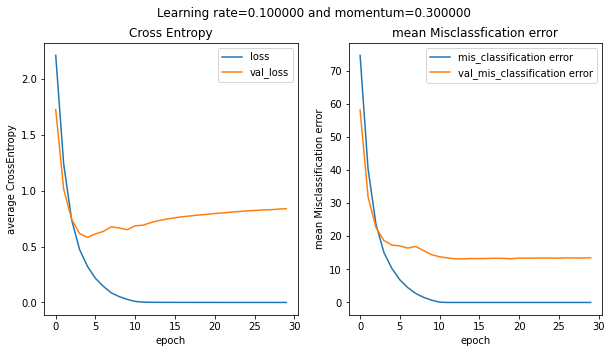

In this case, the misclassification error for vallidation and test set are 14.440000% and 11.940000% respectively.


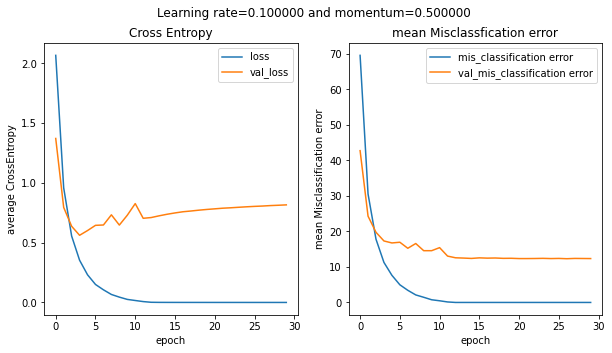

In this case, the misclassification error for vallidation and test set are 14.579999% and 10.760000% respectively.


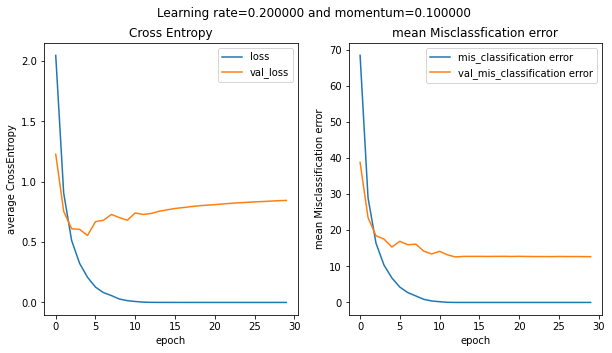

In this case, the misclassification error for vallidation and test set are 13.440001% and 10.640000% respectively.


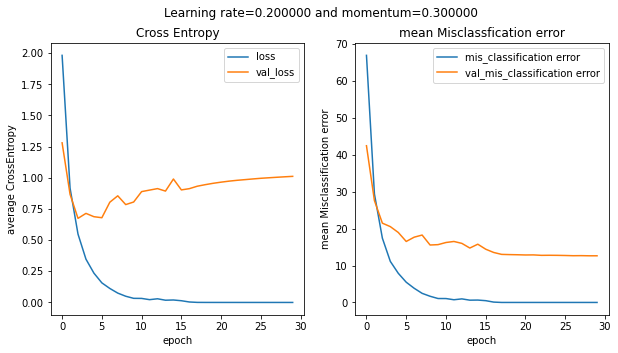

In this case, the misclassification error for vallidation and test set are 15.660000% and 11.920000% respectively.


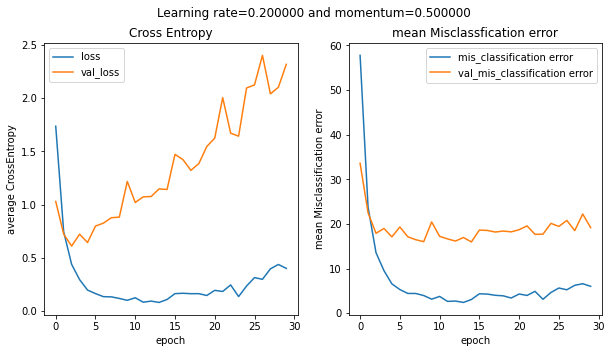

In this case, the misclassification error for vallidation and test set are 20.440000% and 18.420000% respectively.


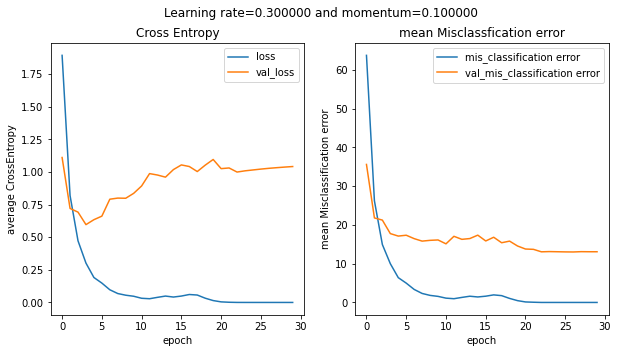

In this case, the misclassification error for vallidation and test set are 16.119999% and 11.600000% respectively.


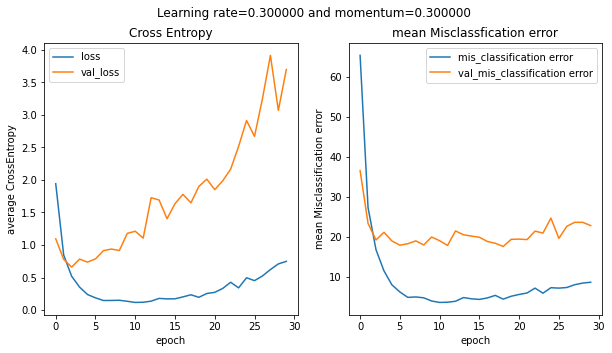

In this case, the misclassification error for vallidation and test set are 19.940001% and 22.880000% respectively.


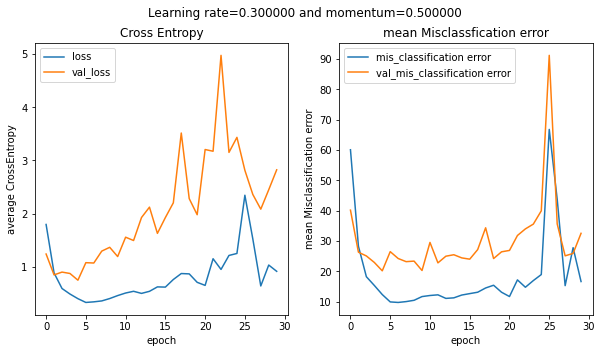

In this case, the misclassification error for vallidation and test set are 20.279998% and 32.100000% respectively.


In [ ]:
for lr in [0.01,0.1,0.2,0.3]:
  for momentum in [0.1,0.3,0.5]:
    np.random.seed(4)
    sgd=keras.optimizers.SGD(learning_rate=lr,momentum=momentum)
    #create model
    cnn_1 = Sequential()
    #add model layers
    cnn_1.add(Conv2D(32, (3,3), activation="relu", input_shape=(28,56,1)))
    cnn_1.add(MaxPooling2D(2, 2))
    cnn_1.add(Flatten())
    cnn_1.add(Dense(64, activation="relu"))
    cnn_1.add(Dense(classes))
    #compile model using accuracy to measure model performance
    cnn_1.compile(optimizer=sgd, loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[SparseCategoricalCrossentropy(),'accuracy'])
    history=cnn_1.fit(X_train,Y_train,epochs=30,validation_data=(X_val,Y_val),verbose=0)
    f,ax=plt.subplots(1,2,figsize=(14,7))
    res=pd.DataFrame(history.history)
    res[['mis_classification error','val_mis_classification error']]=(1-res[['accuracy','val_accuracy']])*100
    res[['loss','val_loss']].plot(figsize=(15,5),ax=ax[0])
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('average CrossEntropy')
    ax[0].set_title('Cross Entropy')
    res[['mis_classification error','val_mis_classification error']].plot(figsize=(10,5),ax=ax[1])
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('mean Misclassification error')
    ax[1].set_title('mean Misclassfication error')
    f.suptitle('Learning rate=%2f and momentum=%2f'%(lr,momentum))
    plt.show()
    pred = np.argmax(cnn_1.predict(X_test),axis=1)
    err_cnn_1 = np.mean(pred!=Y_test)*100
    print("In this case, the misclassification error for vallidation and test set are %3f"%
        (res['val_mis_classification error'][9])+'%', 'and %3f'%(err_cnn_1)+'% respectively.')

From above parameter tuning process, we can see the best model is with parameter $\{lr=0.2,momentum=0.1\}$ with the mean misclassfication error on validation and testing set 13.44% and 10.64% respectively. We also noticed that except when lr=0.01, the epoch times is too much as most training process ends, or the misclassification rate for training or validation set keeps still when epoch goes to around 15, and some cases even have the issue of overfitting. Clearly, this result is still worse than 1.59%. Also, the visualization of the weight is shown below.

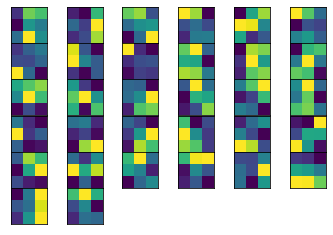

In [ ]:
np.random.seed(4)
sgd=keras.optimizers.SGD(learning_rate=0.2,momentum=0.1)
#create model
cnn_1 = Sequential()
#add model layers
cnn_1.add(Conv2D(32, (3,3), activation="relu", input_shape=(28,56,1)))
cnn_1.add(MaxPooling2D(2, 2))
cnn_1.add(Flatten())
cnn_1.add(Dense(64, activation="relu"))
cnn_1.add(Dense(classes))
#compile model using accuracy to measure model performance
cnn_1.compile(optimizer=sgd, loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[SparseCategoricalCrossentropy(),'accuracy'])
history=cnn_1.fit(X_train,Y_train,epochs=20,validation_data=(X_val,Y_val),verbose=0)
W = cnn_1.layers[0].get_weights()[0].reshape(3,3,-1)
for i in range(W.shape[2]):
  plt.subplot(6,6,i+1)
  plt.imshow(W[:,:,i])
  plt.xticks([])
  plt.yticks([])
plt.subplots_adjust(wspace=0.01,hspace=0.01)
plt.show()

The weight from the best model seems good as it's either not too noisy or too correlated.

### (ii).CNN with three times 2-D Convolution 

Then we do the CNN with 3 times of convolution, and still set `epoch=20`, `seed=4`, `lr=0.1` and `momentum=0.1`. 

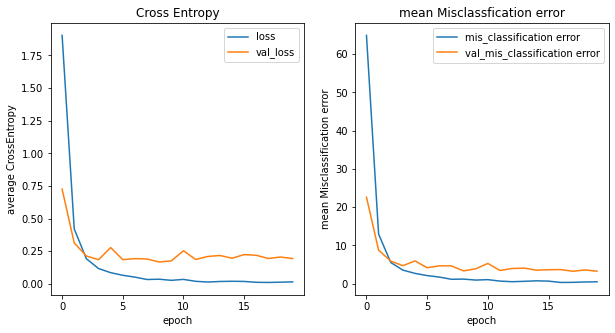

In this case, the misclassification error for vallidation and test set are 3.880000% and 3.040000% respectively.


In [ ]:
np.random.seed(4)
sgd=keras.optimizers.SGD(learning_rate=0.1,momentum=0.1)
#create model
cnn = Sequential()
#add model layers
cnn.add(Conv2D(32, (3,3), activation="relu", input_shape=(28,56,1)))
cnn.add(MaxPooling2D(2, 2))
cnn.add(BatchNormalization())
cnn.add(Conv2D(64, (3,3), activation="relu"))
cnn.add(MaxPooling2D(2, 2))
cnn.add(BatchNormalization())
cnn.add(Conv2D(128, (3,3), activation="relu"))
cnn.add(Flatten())
cnn.add(layers.Dropout(0.2))
cnn.add(Dense(64, activation="relu"))
cnn.add(Dense(classes))
#compile model using accuracy to measure model performance
cnn.compile(optimizer=sgd, loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[SparseCategoricalCrossentropy(),'accuracy'])
history=cnn.fit(X_train,Y_train,epochs=20,validation_data=(X_val,Y_val),verbose=0)
f,ax=plt.subplots(1,2,figsize=(14,7))
res=pd.DataFrame(history.history)
res[['mis_classification error','val_mis_classification error']]=(1-res[['accuracy','val_accuracy']])*100
res[['loss','val_loss']].plot(figsize=(15,5),ax=ax[0])
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('average CrossEntropy')
ax[0].set_title('Cross Entropy')
res[['mis_classification error','val_mis_classification error']].plot(figsize=(10,5),ax=ax[1])
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('mean Misclassification error')
ax[1].set_title('mean Misclassfication error')
plt.show()
pred = np.argmax(cnn.predict(X_test),axis=1)
err_cnn = np.mean(pred!=Y_test)*100
print("In this case, the misclassification error for vallidation and test set are %3f"%
      (res['val_mis_classification error'][9])+'%', 'and %3f'%(err_cnn)+'% respectively.')

We can see the mean misclassification error of this case is 3.04%, which is also more than that in previous question using three times convolution CNN(0.77%). We may see the training error decrease to 0 when epoch goes to around 15 while test error is still around 5%, so we may consider the following parameter tuning process with seed=4, epoch=30 (in case of underfitting), and the parameter set is $\{lr:[0.01,0.1,0.2,0.3], momentum:[0.1,0.3,0.5]\}$.

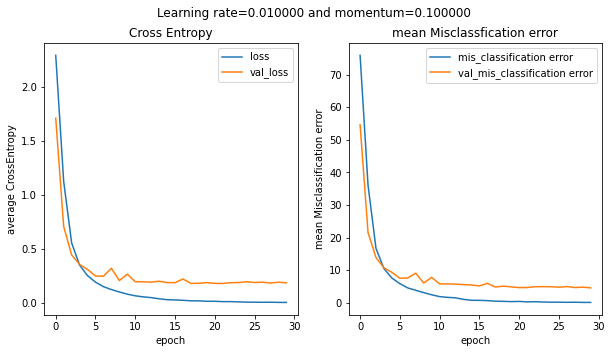

In this case, the misclassification error for vallidation and test set are 7.800001% and 4.400000% respectively.


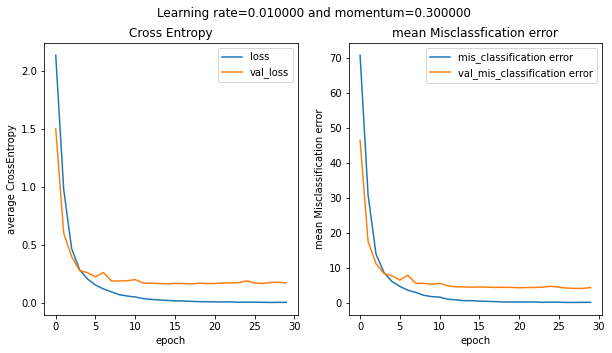

In this case, the misclassification error for vallidation and test set are 5.280000% and 3.880000% respectively.


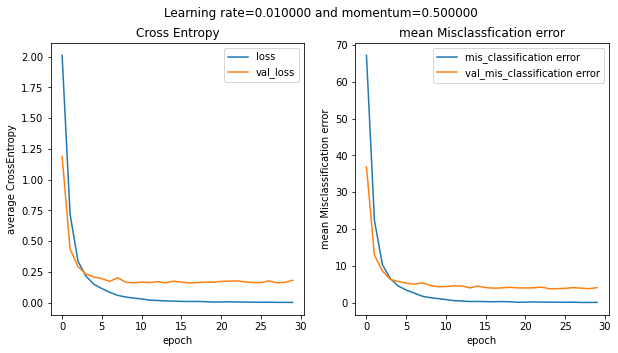

In this case, the misclassification error for vallidation and test set are 4.299998% and 3.780000% respectively.


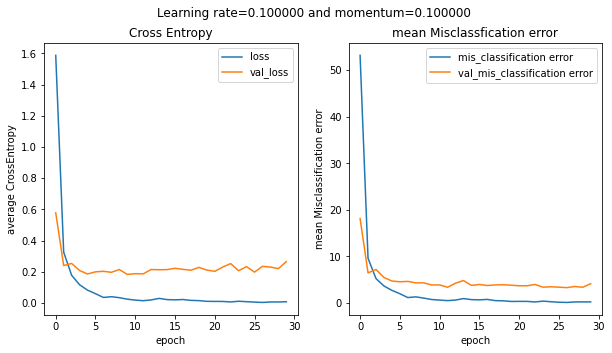

In this case, the misclassification error for vallidation and test set are 3.860003% and 3.680000% respectively.


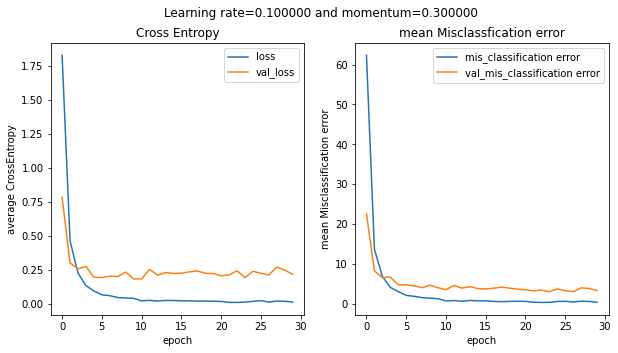

In this case, the misclassification error for vallidation and test set are 3.979999% and 3.020000% respectively.


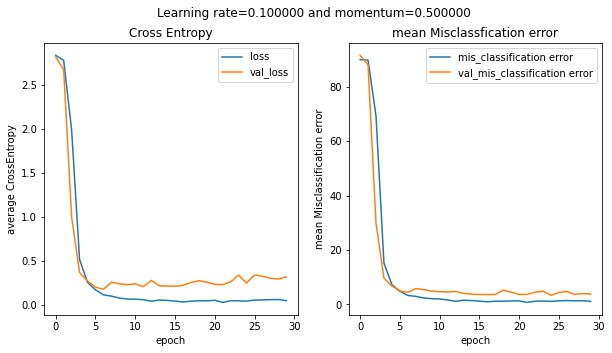

In this case, the misclassification error for vallidation and test set are 4.860002% and 3.760000% respectively.


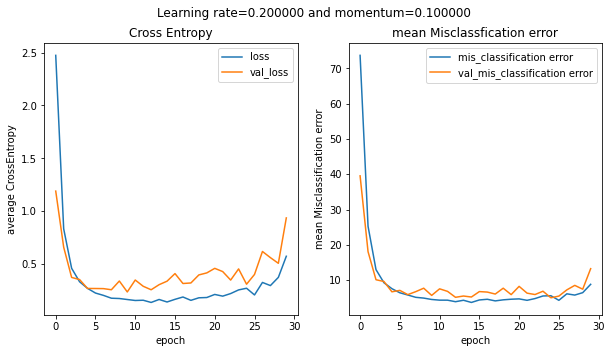

In this case, the misclassification error for vallidation and test set are 5.659997% and 12.860000% respectively.


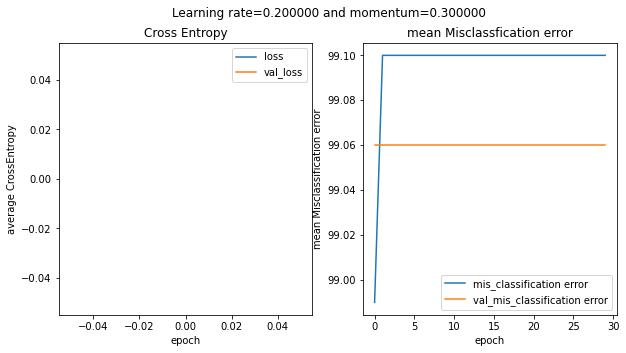

In this case, the misclassification error for vallidation and test set are 99.060000% and 99.120000% respectively.


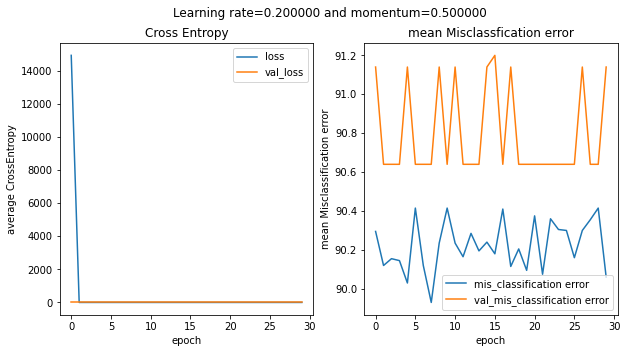

In this case, the misclassification error for vallidation and test set are 90.640000% and 90.980000% respectively.


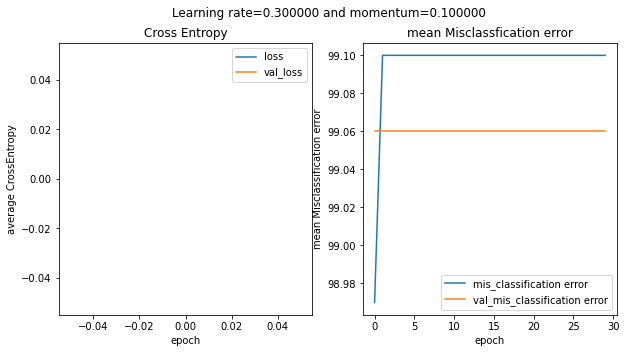

In this case, the misclassification error for vallidation and test set are 99.060000% and 99.120000% respectively.


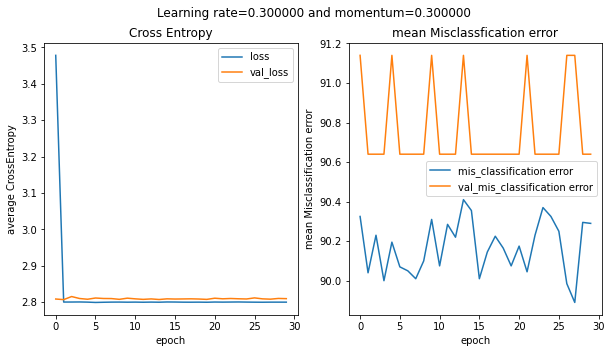

In this case, the misclassification error for vallidation and test set are 91.140000% and 89.300000% respectively.


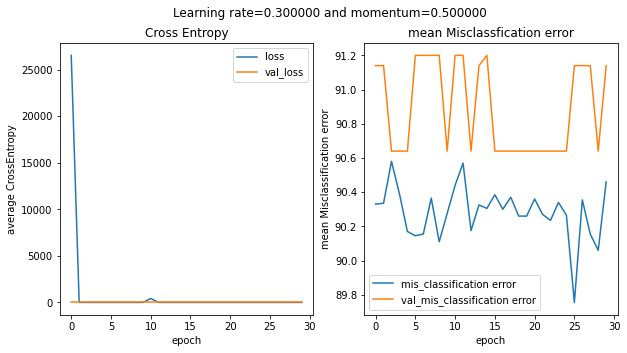

In this case, the misclassification error for vallidation and test set are 90.640000% and 90.980000% respectively.


In [ ]:
for lr in [0.01,0.1,0.2,0.3]:
  for momentum in [0.1,0.3,0.5]:
    np.random.seed(4)
    sgd=keras.optimizers.SGD(learning_rate=lr,momentum=momentum)
    #create model
    cnn = Sequential()
    #add model layers
    cnn.add(Conv2D(32, (3,3), activation="relu", input_shape=(28,56,1)))
    cnn.add(MaxPooling2D(2, 2))
    cnn.add(BatchNormalization())
    cnn.add(Conv2D(64, (3,3), activation="relu"))
    cnn.add(MaxPooling2D(2, 2))
    cnn.add(BatchNormalization())
    cnn.add(Conv2D(128, (3,3), activation="relu"))
    cnn.add(Flatten())
    cnn.add(layers.Dropout(0.2))
    cnn.add(Dense(64, activation="relu"))
    cnn.add(Dense(classes))
    #compile model using accuracy to measure model performance
    cnn.compile(optimizer=sgd, loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[SparseCategoricalCrossentropy(),'accuracy'])
    history=cnn.fit(X_train,Y_train,epochs=30,validation_data=(X_val,Y_val),verbose=0)
    f,ax=plt.subplots(1,2,figsize=(14,7))
    res=pd.DataFrame(history.history)
    res=pd.DataFrame(history.history)
    res[['mis_classification error','val_mis_classification error']]=(1-res[['accuracy','val_accuracy']])*100
    res[['loss','val_loss']].plot(figsize=(15,5),ax=ax[0])
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('average CrossEntropy')
    ax[0].set_title('Cross Entropy')
    res[['mis_classification error','val_mis_classification error']].plot(figsize=(10,5),ax=ax[1])
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('mean Misclassification error')
    ax[1].set_title('mean Misclassfication error')
    f.suptitle('Learning rate=%2f and momentum=%2f'%(lr,momentum))
    plt.show()
    pred = np.argmax(cnn.predict(X_test),axis=1)
    err_cnn = np.mean(pred!=Y_test)*100
    print("In this case, the misclassification error for vallidation and test set are %3f"%
        (res['val_mis_classification error'][9])+'%', 'and %3f'%(err_cnn)+'% respectively.')

From above parameter tuning process, we can see the best model is with parameter $\{lr=0.1,momentum=0.1\}$ with the mean misclassfication error on validation and testing set 3.86% and 3.68% respectively. We also noticed that the epoch times is too much as most training process ends, or the misclassification rate for training or validation set keeps still when epoch goes to around 15, and some even have the overfitting issue. Clearly, this result is still worse than 0.77%. Also, the visualization of the weight is shown below.

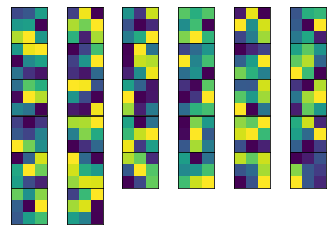

In [ ]:
np.random.seed(4)
sgd=keras.optimizers.SGD(learning_rate=0.1,momentum=0.1)
#create model
cnn = Sequential()
#add model layers
cnn.add(Conv2D(32, (3,3), activation="relu", input_shape=(28,56,1)))
cnn.add(MaxPooling2D(2, 2))
cnn.add(BatchNormalization())
cnn.add(Conv2D(64, (3,3), activation="relu"))
cnn.add(MaxPooling2D(2, 2))
cnn.add(BatchNormalization())
cnn.add(Conv2D(128, (3,3), activation="relu"))
cnn.add(Flatten())
cnn.add(layers.Dropout(0.2))
cnn.add(Dense(64, activation="relu"))
cnn.add(Dense(classes))
#compile model using accuracy to measure model performance
cnn.compile(optimizer=sgd, loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[SparseCategoricalCrossentropy(),'accuracy'])
history=cnn.fit(X_train,Y_train,epochs=20,validation_data=(X_val,Y_val),verbose=0)
W = cnn.layers[0].get_weights()[0].reshape(3,3,-1)
for i in range(W.shape[2]):
  plt.subplot(6,6,i+1)
  plt.imshow(W[:,:,i])
  plt.xticks([])
  plt.yticks([])
plt.subplots_adjust(wspace=0.01,hspace=0.01)
plt.show()

The weight from the best model seems good as it's either not too noisy or too correlated.

Actually, the phenomenon that the misclassification error are all above 1% is explanable. Let's make two assumptions that:
- the lowest error in CNN with three times of 2D convolution be 0.7%.
- The digits are uniformly distributed in 0,1,...,9.

If we consider above process is step by step, i.e. the CNN will predict one digit then another, then the probability of estimating correct sum of two digits will be $$P(sum \ correct)=P(sum \ correct \cap A \& B \ correct)+P(sum \ correct\cap A \& B \ wrong)$$ This is because when one digit is estimated coreectly and the other is wrong, the sum will no longer be correct. Thus, $$P[(A,\ B)\in\{(correct, wrong),(wrong,correct)\}]=2*0.007*0.993=0.013902>0.01$$ 
$$P(sum \ wrong|A \& B \ wrong)>0.007*0.007*(1-\frac{(10/2-1)}{9*9})=0.00004658$$
Thus, we can see the error rate is not possible to be smaller than 1%.

## VI. Conclusion

Based on the MNIST dataset, we first did a series of machine learning methods to learn from handwritten digits and thus further predict handwritten digits. 

We reproduce the methods offered in the paper and found some difference in the results between that in paper and what we did in this project. Overall speaking, *KNN* and *AdaBoost* seem to perform better, *SVM* performs similar but *decision tree* performs worse because of curse of dimensionality and not using CART. Then we did parameter tuning on *SVM* and use better parameter to outperform all algorithms above.

Then we continue with 3 deep learning method including *1 layer NN*, *CNN with 1 time convolution* and *CNN with 3 times convolution* on this dataset. For every method, we use cross entropy loss and accuracy as the metric for the algorithm, do parameter tuning for a best output and visualize the weights.

Based on upon algorithms, we also use a new dataset which X_train is the conposition of two digits and Y_train is the sum of the two digits. Still, we use the algorithms that perform best and second best on this dataset. All results with best parameter sets in above analysis are listed below:

**MNIST Dataset**: (Test Error)
- 3.05% for KNN(n_neighbors=3)
- 4.18% for Adaboost(tree(max_depth=30),n_estimator=15)
- 13.54% for DecisionTree((seed=20,min_samples_split=8,min_samples_leaf=6,max_depth=15)
- 1.66% for SVM(kernel='rbf',C=3)
- 2.92% for RandomForest(seed=20,n_estimators=200,max_depth=20)
- 1.57% for SVM(kernel='rbf',C=4)
- 1.80% for 1_layer_NN(SGD(lr=0.2,momentum=0.5),seed=4,epoch=150)
- 1.11% for 1_Conv_CNN(SGD(lr=0.2,momentum=0.5),seed=4,epoch=20)
- 0.77% for 3_Conv_CNN(SGD(lr=0.1,momentum=0.1),seed=4,epoch=20)

**MNIST Arithmetic Dataset**: (Test Error)
- 10.64% for 1_Conv_CNN(SGD(lr=0.2,momentum=0.1),seed=4,epoch=30)
- 3.68% for 3_Conv_CNN(SGD(lr=0.1,momentum=0.1),seed=4,epoch=30)
